In [1]:
import surprise
import pandas as pd
import numpy as np
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
from operator import itemgetter
import heapq
import os
import csv

In [2]:
# Import the data
ratings_url = "https://raw.githubusercontent.com/TannerGilbert/Tutorials/master/Recommendation%20System/ratings.csv"
ratings = pd.read_csv(ratings_url)
df_ratings = pd.read_csv(ratings_url, usecols = ['user_id', 'book_id', 'rating'], 
                         dtype = {'user_id': 'int32', 'book_id': 'int32', 'rating': 'float32'})

books_url = "https://raw.githubusercontent.com/TannerGilbert/Tutorials/master/Recommendation%20System/books.csv"
books_og = pd.read_csv(books_url)
df_books = pd.read_csv(books_url, usecols = ['book_id', 'title'], dtype = {'book_id': 'int32', 'title': 'str'})

In [3]:
# View info about the data
df_books.info()
print("=====================")
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   book_id  10000 non-null  int32 
 1   title    10000 non-null  object
dtypes: int32(1), object(1)
memory usage: 117.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   book_id  981756 non-null  int32  
 1   user_id  981756 non-null  int32  
 2   rating   981756 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 11.2 MB


In [4]:
# View the first 5 rows of df_books 
df_books.head()
# df_ratings.head()

,book_id,title
0,2767052,"The Hunger Games (The Hunger Games, #1)"
1,3,Harry Potter and the Sorcerer's Stone (Harry P...
2,41865,"Twilight (Twilight, #1)"
3,2657,To Kill a Mockingbird
4,4671,The Great Gatsby


In [5]:
# View number of users and books in the ratings data
num_users = len(df_ratings.user_id.unique())
num_items = len(df_ratings.book_id.unique())
print('There are {} unique users and {} unique books in this data set'.format(num_users, num_items))

There are 53424 unique users and 10000 unique books in this data set


In [6]:
# View the count of each rating
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns = ['count'])
df_ratings_cnt_tmp

,count
rating,
1.0,19575
2.0,63231
3.0,248623
4.0,357366
5.0,292961


In [7]:
# Not every user can review every book so there are lots of 0 counts
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

# Append counts of 0 rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index = [0]),
    verify_integrity = True,
).sort_index()
df_ratings_cnt

,count
0.0,533258244
1.0,19575
2.0,63231
3.0,248623
4.0,357366
5.0,292961


In [8]:
# count for 0 rating score is too big to compare with others so we log transform for count values
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,533258244,20.094516
1.0,19575,9.882009
2.0,63231,11.054550
3.0,248623,12.423693
4.0,357366,12.786516
5.0,292961,12.587795


In [9]:
# Rating frequency of books
df_books_cnt = pd.DataFrame(df_ratings.groupby('book_id').size(), columns = ['count'])
df_books_cnt.tail()

,count
book_id,
9996,98
9997,89
9998,95
9999,99
10000,96


Text(0, 0.5, 'Number of ratings')

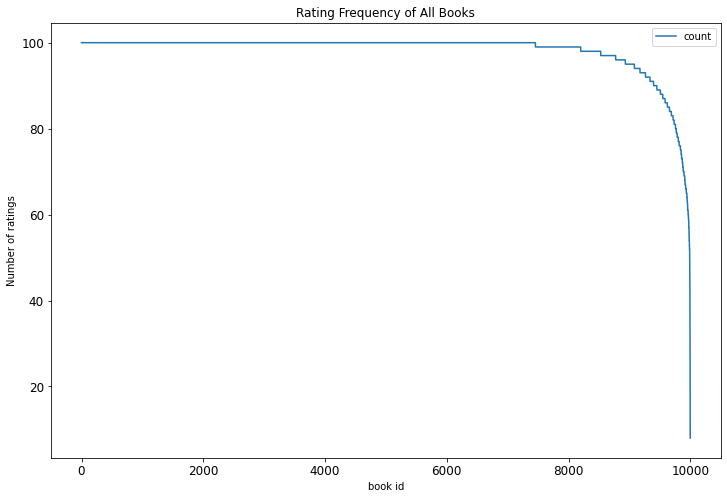

In [40]:
# Plot the number of ratings for books

ax = df_books_cnt.sort_values('count', ascending = False).reset_index(drop = True).plot(
        figsize = (12,8),
        title = 'Rating Frequency of All Books',
        fontsize = 12)
ax.set_xlabel('book id')
ax.set_ylabel('Number of ratings')

Text(0, 0.5, 'Number of ratings (log scale)')

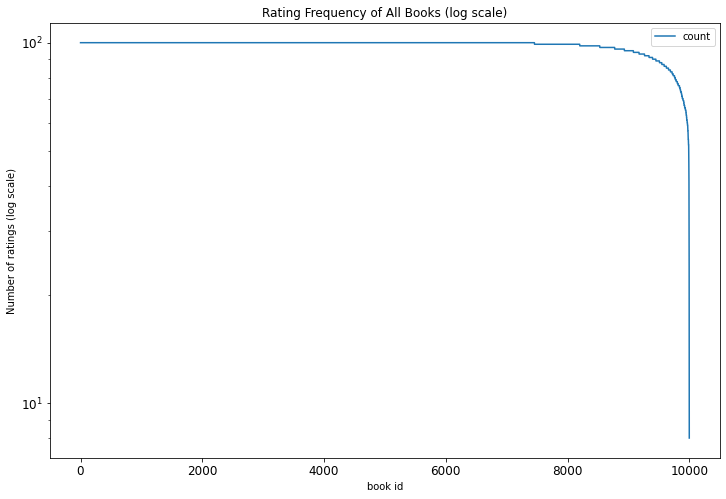

In [11]:
# Plot the number of ratings per book with log function

ax = df_books_cnt.sort_values('count', ascending = False).reset_index(drop = True).plot(
        figsize = (12,8),
        title = 'Rating Frequency of All Books (log scale)',
        fontsize = 12,
        logy = True)
ax.set_xlabel('book id')
ax.set_ylabel('Number of ratings (log scale)')

In [39]:
# Remove books that were rated less than 50 times
popularity_thresh = 50
popular_books = list(set(df_books_cnt.query('count >= @popularity_thresh').index))
df_ratings_drop_books = df_ratings[df_ratings.book_id.isin(popular_books)]
print('Shape of og ratings data: ', df_ratings.shape)
print('Shape of ratings data after dropping less popular books: ', df_ratings_drop_books.shape)

Shape of og ratings data:  (981756, 3)
Shape of ratings data after dropping less popular books:  (981417, 3)


In [13]:
# View quickly how many ratings people do
df_users_cnt = pd.DataFrame(df_ratings_drop_books.groupby('user_id').size(), columns = ['count'])
df_users_cnt.head(20)

,count
user_id,
1,3
2,3
3,2
4,3
5,5
6,2
7,76
8,3
9,7


In [14]:
# look at how many users rated more than x amount of times
amount_of_times = 3
more_than_x_ratings = df_users_cnt[df_users_cnt['count'] >= amount_of_times]
more_than_x_ratings.count()

count    45076
dtype: int64

In [41]:
# Filter out the users who reviewed less than 3 times
ratings_thresh = 3
active_users = list(set(df_users_cnt.query('count >= @ratings_thresh').index))
df_ratings_drop_users = df_ratings_drop_books[df_ratings_drop_books.user_id.isin(active_users)]
print('Shape of og ratings data: ', df_ratings.shape)
print('Shape of ratings data after dropping less popular books : ', df_ratings_drop_users.shape)

Shape of og ratings data:  (981756, 3)
Shape of ratings data after dropping less popular books :  (964808, 3)


In [16]:
# Keep 3 columns of the new ratings dataframe where we dropped the less popular books and people who didnt rate much
df_ratings_drop_users = df_ratings_drop_users[['book_id', 'user_id', 'rating']]
df_ratings_drop_users

,book_id,user_id,rating
0,1,314,5.0
1,1,439,3.0
2,1,588,5.0
3,1,1169,4.0
4,1,1185,4.0
...,...,...,...
981751,10000,48386,5.0
981752,10000,49007,4.0
981753,10000,49383,5.0
981754,10000,50124,5.0


In [17]:
# New dataframe of merged ratings dataframe and the book df with the book title
merged = pd.merge(df_ratings_drop_users, df_books, on = 'book_id', how = 'left')
merged2 = merged.dropna()
merged2

,book_id,user_id,rating,title
0,1,314,5.0,Harry Potter and the Half-Blood Prince (Harry ...
1,1,439,3.0,Harry Potter and the Half-Blood Prince (Harry ...
2,1,588,5.0,Harry Potter and the Half-Blood Prince (Harry ...
3,1,1169,4.0,Harry Potter and the Half-Blood Prince (Harry ...
4,1,1185,4.0,Harry Potter and the Half-Blood Prince (Harry ...
...,...,...,...,...
964614,9998,51295,5.0,The Woman in the Dunes
964615,9998,51559,5.0,The Woman in the Dunes
964616,9998,52087,4.0,The Woman in the Dunes
964617,9998,52330,4.0,The Woman in the Dunes


In [18]:
# Keep only the title, user_id and rating columns from the merged dataframe
df = merged2[['title','user_id','rating']]
df

,title,user_id,rating
0,Harry Potter and the Half-Blood Prince (Harry ...,314,5.0
1,Harry Potter and the Half-Blood Prince (Harry ...,439,3.0
2,Harry Potter and the Half-Blood Prince (Harry ...,588,5.0
3,Harry Potter and the Half-Blood Prince (Harry ...,1169,4.0
4,Harry Potter and the Half-Blood Prince (Harry ...,1185,4.0
...,...,...,...
964614,The Woman in the Dunes,51295,5.0
964615,The Woman in the Dunes,51559,5.0
964616,The Woman in the Dunes,52087,4.0
964617,The Woman in the Dunes,52330,4.0


In [19]:
# Create pivot table with book_id as rows and user_id as the column and rating as the values
merged_drop_users = df.pivot_table(index = 'title', columns = 'user_id', 
                                  values = 'rating', aggfunc = 'mean', fill_value = 0)

In [20]:
# View the matrix with the title of the books as rows and user_id as columns
merged_drop_users.head()

user_id,2,4,7,9,10,11,14,19,20,22,...,53400,53401,53403,53404,53406,53409,53419,53420,53422,53424
title,,,,,,,,,,,,,,,,,,,,,
'Salem's Lot,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"'Tis (Frank McCourt, #2)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1421: The Year China Discovered America,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Create the csr matrix for the book, user, rating matrix. 
# Sparse matrix = more efficient calculation and less memory footprint 
user_book_table_matrix = csr_matrix(merged_drop_users.values)

# Define the model
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = 20, n_jobs = 1)

# fit the model
knn.fit(user_book_table_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=1, n_neighbors=20)

In [37]:
def book_recs(choice, num_recs):
    
    # Create book and distance lists for when we want to display the top 10
    book = []
    distance = []
    
    # Find the book index of the book that the user selected as their favourite
    book_index = np.where(merged_drop_users.index == choice)

    # Find the number index of corresponding to the book index
    query_index = book_index[0]
    
    # Back to the title of the book from the index. Just doing this to get the title directly from the table
    # but since the user writes the title of the book they want we could just use that
    chosen_book_with_index = merged_drop_users.index[query_index][0]
    
    # Calculate the distances and index of where the book is located to calculate the closest other books
    distances, indices = knn.kneighbors(merged_drop_users.iloc[query_index, :].values.reshape(1,-1),
                                    n_neighbors = num_recs+1) # n_neighbors = number of recommendations we want

    # For all the books, add to the lists of book, distance so we can rank them and take top 10
    for i in range(0,len(distances.flatten())):
        if i != 0:
            book.append(merged_drop_users.index[indices.flatten()[i]])
            distance.append(distances.flatten()[i])

    # Create a 1-dimension array with book and distance lists
    m = pd.Series(book, name = 'book')
    d = pd.Series(distance, name = 'distance')
    
    # create concatenated array with both arrays above 
    recommend = pd.concat([m,d], axis = 1)
    
    # sort the values based on the distance
    recommend = recommend.sort_values('distance', ascending = False)

    # Print the recommendations
    print('Recommendations for {0}:\n'.format(chosen_book_with_index))
    for i in range(0, recommend.shape[0]):
        print('{0}: {1}, with distance of {2:.2f}'.format(i+1, recommend['book'].iloc[i], 
                                                          recommend['distance'].iloc[i]))

In [38]:
# Call the function for a specific book and number of recommendations we want
book_recs('A Lesson Before Dying', 5)

Recommendations for A Lesson Before Dying:

1: His Excellency: George Washington, with distance of 0.87
2: Open House, with distance of 0.86
3: In Our Time, with distance of 0.85
4: From the Mixed-Up Files of Mrs. Basil E. Frankweiler, with distance of 0.84
5: Kafka on the Shore, with distance of 0.82
